# Fiabilité et propagation d'incertitude

# Auteurs : HOUSSENALY Ali, DACHER Maël

# 0) Import des bibliothèques Python

In [1]:
import numpy as np
import scipy as sci
import openturns as ot
import math
import scipy.stats as stat
import scipy.optimize as opt
import time as t #utile pour mesurer le temps d'execution des fonctions
import matplotlib.pyplot as plt
from smt.surrogate_models import KRG
# %matplotlib inline

# 1) Description du problème
## 1-1) Introduction

On souhaite étudier la fiabilité d'une passerelle soumise à un chargement réparti sur son tablier. Pour cela, la passerelle est modélisée par une poutre de longueur $L$, encastrée à son extrémité gauche et en appui simple à son extrémité droite, le chargement est noté $Q(l)$. La passerelle est de section rectangulaire de base $b$ et de hauteur $h$. Le module d'élasticité du matériau servant à la construction de la passerelle est $E$. La défaillance est caractérisée par un déplacement maximal autorisé noté $u_{max}$.

La résolution de l'équation de la statique permettant de trouver le déplacement de la passerelle est effectuée par la méthode des éléments finis.


## 1-2) Résolution par la méthode des éléments finis

Le nombre d'éléments est noté $n_{elem}$. On suppose que le chargement réparti est vertical et compte $n_{nodes}=n_{elem}+1$ composantes notées $Q_i,~i=1,\cdots,n_{nodes}$. Le code suivant crée la fonction Python qui résout l'équation de la statique par la méthode des éléments finis et renvoie le déplacement max de la structure. Pour cela $n_{elem}$ éléments de poutre à 2 degrés de liberté par noeud sont utilisés.

In [2]:
def u_structure(n_elem,L,E,I,Q):

        #matrice de rigidité totale
        K = np.zeros((2*(n_elem+1),2*(n_elem+1)))
        #Longeur des éléments
        l = L/n_elem
        #boucle sur les éléments
        for i in range(n_elem):
            #matrice élémentaire
            K_elem = E*I/l**3*np.array([[12.0,6.0*l,-12.0,6.0*l],\
                                        [6.0*l,4.0*l**2,-6.0*l,2.0*l**2],\
                                       [-12.0,-6.0*l,12.0,-6.0*l],\
                                       [6*l,2.0*l**2,-6.0*l,4.0*l**2]])
            #Assemblage
            K[2*i:2*(i+1),2*i:2*(i+1)] = K[2*i:2*(i+1),2*i:2*(i+1)] + K_elem[0:2,0:2]
            K[2*(i+1):2*(i+2),2*i:2*(i+1)] = K[2*(i+1):2*(i+2),2*i:2*(i+1)] + K_elem[2:4,0:2]
            K[2*i:2*(i+1),2*(i+1):2*(i+2)] = K[2*i:2*(i+1),2*(i+1):2*(i+2)] + K_elem[0:2,2:4]
            K[2*(i+1):2*(i+2),2*(i+1):2*(i+2)] = K[2*(i+1):2*(i+2),2*(i+1):2*(i+2)] + K_elem[2:4,2:4]
            #conditions aux limites
        #encastrement en l = 0
        K[0:2,:] = 0.0
        K[:,0:2] = 0.0
        K[0,0] = 1.0
        K[1,1] = 1.0
        #appui simple en l = L
        K[-2,:] = 0.0
        K[:,-2] = 0.0
        K[-2,-2] = 1.0
        #Decomposition de Cholesky
        K_fact = sci.linalg.cho_factor(K)
        #Second membre
        F = np.zeros((2*(n_elem+1),))
        F[0:-1:2] = Q
        F[0:2] = 0.0
        F[-2] = 0.0
        #resolution du système KU = F
        U = sci.linalg.cho_solve(K_fact,F)
        return U

def interpolation_EF(X,U,L):
    n_elem = len(U)/2-1
    l = L/n_elem
    U_X = np.zeros(X.shape)
    i = 0
    for x in X:
        #on cherche à quel élément appartient x et quelle est sa position relative
        n = int((x-1e-12)/l) #on se décale très légèrement sur la gauche
        #pour ne pas avoir de problème en x=L qui donnerait n=en_elem +1 et qui poserait problème
        s = (x-(n*l))/l
        #On recupère U_i et U_j correspondant
        u_i = U[2*n]
        theta_i = U[2*n+1]
        u_j = U[2*(n+1)]
        theta_j = U[2*(n+1)+1]
        u_x = u_i*(1.0-3.0*s**2+2.0*s**3)+u_j*(3.0*s**2-2.0*s**3)\
        +theta_i*(l*(s-2.0*s**2+s**3))+theta_j*(l*(-s**2+s**3))
        U_X[i] = u_x
        i = i+1
    return U_X

def find_max_dep(n_elem,L,E,I,Q):
    #On commence par résoudre le problème discrétisé
    U = u_structure(n_elem,L,E,I,Q)
    #Puis on cherche le min du problème continu grace à la fonction d'interpolation
    res_opt = opt.minimize(interpolation_EF,np.array([L/2.0]),method = "SLSQP", bounds=[[0.0,L]],args=(U,L),tol=1e-12)
    u_max = res_opt['fun']
    l_max = res_opt['x']
    return l_max,u_max,U

<div class="alert alert-danger "><b>  Dans la suite on fixera $L=10.0$, $b=1.0$, $h=0.1$, $E =12e^9$, $Q_{total} = -3000$, $n_{elem}=50$ </b></div>

# 2) Propagation d'incertitude et analyse de sensibilité

On suppose à présent que les varibales $b$ et $E$ sont aléatoires. L'objectif est de modéliser ces variables incertaines puis de faire une analyse de sensibilité du déplacement. Pour cela nous calculerons les indices de sensibilité basés sur la décomposition de la variance (indice de Sobol).

## 2-1) Modèle probabiliste des variables $b$ et $E$

Dans la suite on suppose que le code EF ci dessus donne la **valeur exacte** du déplacement maximal de la passerelle.
Dans cet exercice nous allons considérer que les paramètres $E$ et $b$ sont des variables aléatoires indépendantes telles que :
- $E$ suit une loi log-normale de moyenne $\mu_E=12e9$ et de coefficient de variation $10\%$ http://openturns.github.io/openturns/latest/user_manual/_generated/openturns.LogNormal.html?highlight=lognormal. Remarque : $X$ de loi log-normale, $\mu_X= E[X]$, $\sigma_X=\sqrt{Var[X]}$, il existe une unique variable $Y$ de loi normale telle que $ln(X) = Y$ de moyenne $\mu_Y=\lambda_X$ et d'ecart type $\sigma_Y=\xi_X$ et nous avons
$$
\lambda_X = ln\left( \frac{\mu_X}{\sqrt{1+(\frac{\sigma_X}{\mu_X})^2}}\right)
$$
$$
\xi_X = \sqrt{ ln(1+(\frac{\sigma_X}{\mu_X})^2)}
$$

- $b$ suit une loi uniforme sur $[0.9,1.1]$ http://openturns.github.io/openturns/latest/user_manual/_generated/openturns.Uniform.html?highlight=uniform




<p class="bg-primary" style="padding:1em"> 

Le code ci dessous créer le modèle probabiliste des variables $E$ et $b$.</p>

In [3]:
mean_E = 12e9
cv_E = 0.1
Lambda_E = np.log(mean_E/(np.sqrt(1.+cv_E**2)))
Xi_E = np.sqrt(np.log(1.+cv_E**2))
Loi_E = ot.LogNormal(Lambda_E,Xi_E)
print ("mu_E =",Loi_E.getMean()[0],", cv_E=", Loi_E.getStandardDeviation()[0]/Loi_E.getMean()[0])
b_inf = 0.9
b_sup = 1.1
Loi_b = ot.Uniform(0.9,1.1)
print ("mu_b=",Loi_b.getMean()[0],", cv_b=", Loi_b.getStandardDeviation()[0]/Loi_b.getMean()[0])

mu_E = 11999999999.999966 , cv_E= 0.10000000000000019
mu_b= 1.0 , cv_b= 0.0577350269189626


## 2.2) Propagation d'incertitude par chaos polynomial
L'objectif de cette partie est de construire une approximation par chaos polynomial de la fonction $U_{max}(E,b)$.

$$
U_{max}(E,b) \approx \hat{U}_{max}(E,b)=\sum_{i=1}^P \alpha_i \phi_i(E,b)  
$$

Pour cela nous utilisons l'objet FunctionalChaosAlgorithm d'openturns (http://openturns.github.io/openturns/latest/user_manual/response_surface/_generated/openturns.FunctionalChaosAlgorithm.html)



<p class="bg-primary" style="padding:1em">

**Question 1)** :  Comment est construite la base de polynômes $\Phi=\left\lbrace \phi_i(E,b) \right\rbrace_{i\in\mathbb{N}}$? Quelles sont les familles de polynômes utilisées?

Vérifier votre réponse en complétant le code ci-dessous à l'aide de la fonction StandardDistributionPolynomialFactory (http://openturns.github.io/openturns/latest/user_manual/_generated/openturns.StandardDistributionPolynomialFactory.html#openturns.StandardDistributionPolynomialFactory)
</p>

In [4]:
#construction de la base de polynômes
#polynomes orthogonaux par rapport à E
P_E = ot.StandardDistributionPolynomialFactory(Loi_E) #A Completer
print(P_E)
#polynomes orthogonaux par rapport à b
P_b = ot.StandardDistributionPolynomialFactory(Loi_b) #A Completer
print(P_b)
#tensorisation des deux familles
base = ot.OrthogonalProductPolynomialFactory([P_E,P_b])

class=StandardDistributionPolynomialFactory hasSpecificFamily=false orthonormalization algorithm=class=OrthonormalizationAlgorithm implementation=class=AdaptiveStieltjesAlgorithm measure=class=LogNormal name=LogNormal dimension=1 muLog=23.2032 sigmaLog=0.0997513 gamma=0 monicRecurrenceCoefficients=class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=2 dimension=3 data=[[1,-1.2e+10,0],[1,-1.23612e+10,-1.44e+18]] monicSquaredNorms=class=Point name=Unnamed dimension=2 values=[1,1.44e+18] isElliptical=false
class=StandardDistributionPolynomialFactory hasSpecificFamily=true specificFamily=class=OrthogonalUniVariatePolynomialFamily implementation=class=LegendreFactory measure=class=Uniform name=Uniform dimension=1 a=-1 b=1


**Réponse 1)** : La base de polynômes est construite à partir des distributions de probabilité des variables aléatoires d'entrée. Pour chaque variable aléatoire, on associe une famille de polynômes orthogonaux qui sont orthogonaux par rapport à la distribution de cette variable.

<p class="bg-primary" style="padding:1em">

**Question 2)** : Proposer une solution afin d'eviter le calcul numérique de la familles de polynômes orthogonaux par rapport à la la loi de $E$</p>

**Réponse** : Pour éviter le calcul numérique de la familles de polynômes orthogonaux par rapport à la la loi de $E$ on peut essayer d'appliquer des transformations pour se ramener à la loi normale standard et appliquer ensuite les polynômes d'Hermite.

<p class="bg-primary" style="padding:1em">

**Question 3)** : On souhaite que la base $\Phi$ contienne tous les polynômes jusqu'au degré 3, déterminer la valeur de $P$. *(indice : math.factorial())*</p>

In [5]:
n = 2
d = 3
P = int(math.factorial(d+n-1)/(math.factorial(d)*math.factorial(n-1)))
print ('P=',P)

P= 4


<p class="bg-primary" style="padding:1em">

**Question 4)** : Nous proposons d'utiliser le calcul des coefficients par moindre carrée, pour cela on utilisera un échantillon de taille $3P$. Compléter le code suivant afin de créer cet échantillon

In [6]:
##génération d'échantillons
n_sim = 3*P #A Completer
Echantillon_E = np.array([Loi_E.getSample(n_sim)]).flatten()
Echantillon_b = np.array([Loi_b.getSample(n_sim)]).flatten()
##paramètres
L = 10.0 #longueur en métre
h = 0.1 #hauteur de la section en métre
#Chargement :
#Chargement total
Q_total = -3000.0 #Newton
#Le chargement est réparti uniformément sur les noeuds entre les 2 extremitées
n_elem = 50
n_nodes = n_elem+1
Q_elem = Q_total/n_elem
Q = np.ones((n_nodes,))*Q_elem
#Vecteur U_max
U_max = np.zeros((n_sim,))
##Exécution du code EF pour chaque échantillon
for i in range(n_sim):
    E = Echantillon_E[i]
    b = Echantillon_b[i]
    I = b*h**3/12.0
    l_max,u_max,U = find_max_dep(n_elem, L, E, I, Q) #A Completer
    U_max[i] = u_max #A Completer

<p class="bg-primary" style="padding:1em">

**Question 5)** : Completer le code suivant qui créer l'approximation par chaos polynômial à l'aide d'openturns. Pour cela utiliser la doc http://openturns.github.io/openturns/latest/user_manual/response_surface/_generated/openturns.FunctionalChaosAlgorithm.html

In [7]:
input_distribution = ot.ComposedDistribution([Loi_E, Loi_b]) #A Completer
adaptiveStrategy = ot.FixedStrategy(base, 3) #A Completer
Echantillon_E = Echantillon_E.reshape(-1, 1)
Echantillon_b = Echantillon_b.reshape(-1, 1)
input_sample = np.concatenate((Echantillon_E,Echantillon_b),axis=1)
output_sample= U_max.reshape((3*P,1))
#Par defaut la méthode utilise les moindres carrés, il n'est donc pas utile de spécifier la projection strategy
CP = ot.FunctionalChaosAlgorithm(input_sample, output_sample, input_distribution, adaptiveStrategy) #A Completer,#A Completer,#A Completer,#A Completer
CP.run()
result_CP = CP.getResult()
print(result_CP.getCoefficients())
print(result_CP.getComposedMetaModel())

0 : [ -0.0165301   ]
1 : [  0.0017876   ]
2 : [  0.000961978 ]
-0.0165301 + 0.0017876 * (-10 + 8.33333e-10 * x0) + 0.000961978 * (1.73205 * x1)


Maintenant que l'approximation par chaos polynomial est créée il est possible de l'exploiter directement à l'aide des resultats (getResult) ou en créant un métamodèle (result.getMetaModel()) ou à l'aide d'un FunctionalChaosRandomVector (https://openturns.github.io/openturns/latest/user_manual/_generated/openturns.FunctionalChaosRandomVector.html?highlight=functionalchaos#openturns.FunctionalChaosRandomVector)


<p class="bg-primary" style="padding:1em">

**Question 6)** : Compléter le code suivant permettant de tester l'approximation obtenue à l'aide d'un echantillon de validation. En utilisant l'objet MetaModelValidation d'openTurns calculer l'indicateur R2. Que représente cette valeur? Que pouvez vous conclure sur la qualité de votre métamodèle?

Predictivity factor  [0.949479]


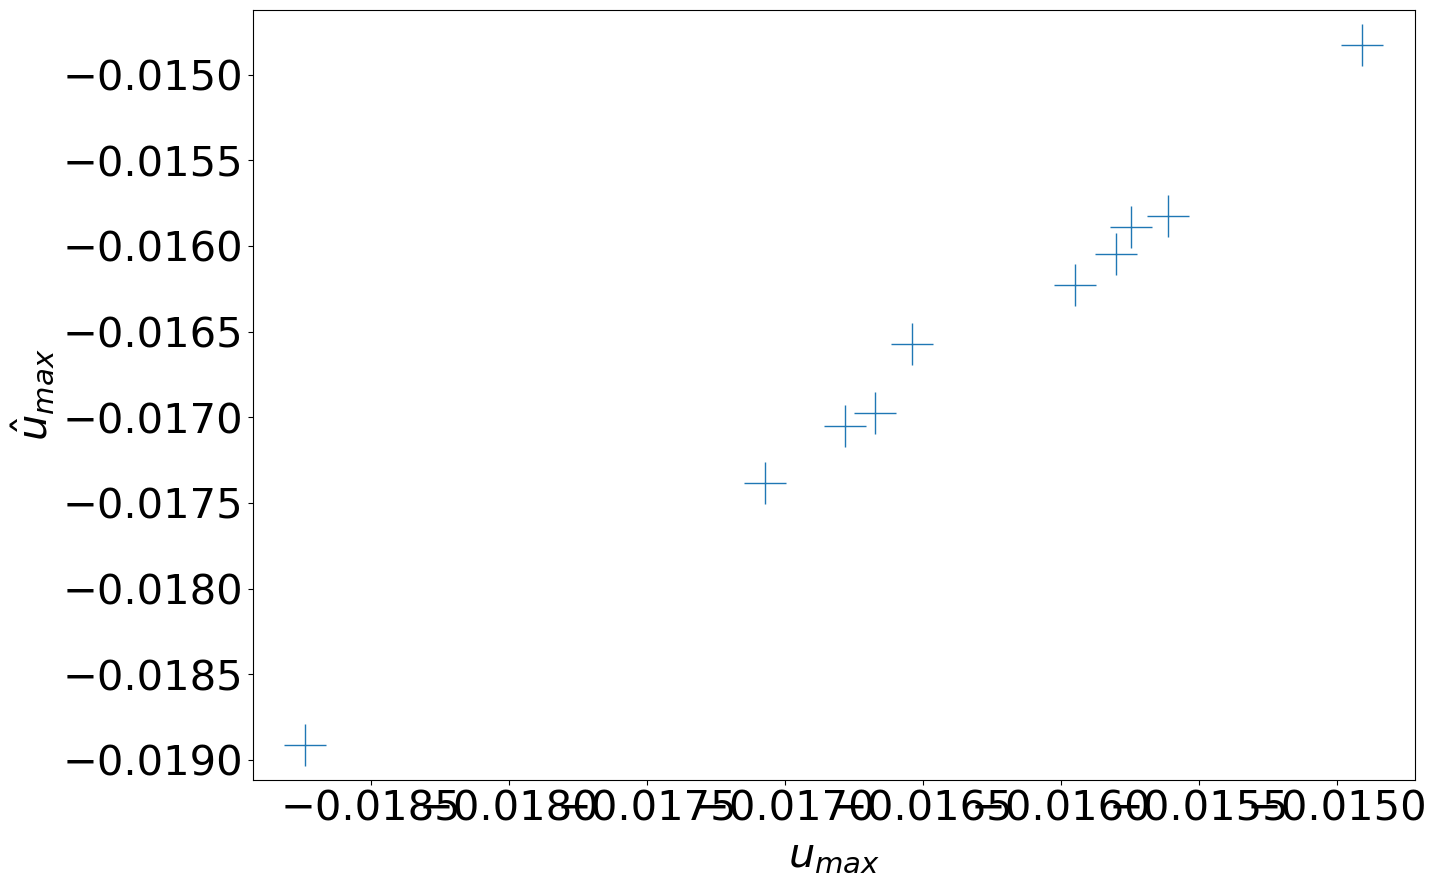

In [11]:
n_validation = 10
Echantillon_validation = input_distribution.getSample(n_validation)
U_max = np.zeros((n_validation,1))
##Exécution du code EF pour chaque échantillon
for i in range(n_validation):
    E = Echantillon_validation[i,0]
    b = Echantillon_validation[i,1]
    I = b*h**3/12.0
    l_max,u_max,U = find_max_dep(n_elem,L,E,I,Q)
    U_max[i] = u_max
Meta_model = result_CP.getMetaModel() #A Completer
U_CP = Meta_model(Echantillon_validation)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$u_{max}$',fontsize = 30)
ax.set_ylabel (r'$\hat{u}_{max}$',fontsize=30)
ax.tick_params(labelsize=30)
ax.plot(U_max,U_CP,'+',markersize= 30)

#Q2 predictivity factor
# Validation of the model
val = ot.MetaModelValidation(U_max, U_CP) # A COMPLETER
# Compute the first indicator : R2
R2 = val.computeR2Score() #A COMPLETER
print('Predictivity factor ', R2)

**Réponse 6)**  : L'indicateur R2 représente la proportion de la variance de la variable dépendante qui est expliquée par le modèle. Une valeur de R2 proche de 1 indique que le modèle explique bien les données, tandis qu'une valeur proche de 0 indique que le modèle n'explique pas bien les données. On obtient ici : $R^2 \approx 0.95$, on en déduit que le métamodèle explique bien les données et que l'approximation par chaos polynomial est de bonne qualité.

<p class="bg-primary" style="padding:1em">

**Question 7)** : Estimer la moyenne et la variance de $U_{max}$ à l'aide de l'approximation par CP.


In [81]:
coefs = np.array(result_CP.getCoefficients()) # A Completer
print("Mean=", np.mean(coefs)) # A Completer
print("Variance=", np.var(coefs))# A Completer

Mean= -0.0043397598170147106
Variance= 7.06449693265057e-05


Nous allons à present observer la convergence de la moyenne et de la variance en fonction du degré de l'approximation.

<p class="bg-primary" style="padding:1em">

**Question 8)** : Que pouvez vous en conclure sur la fonction $U_{max}(E,b)$?

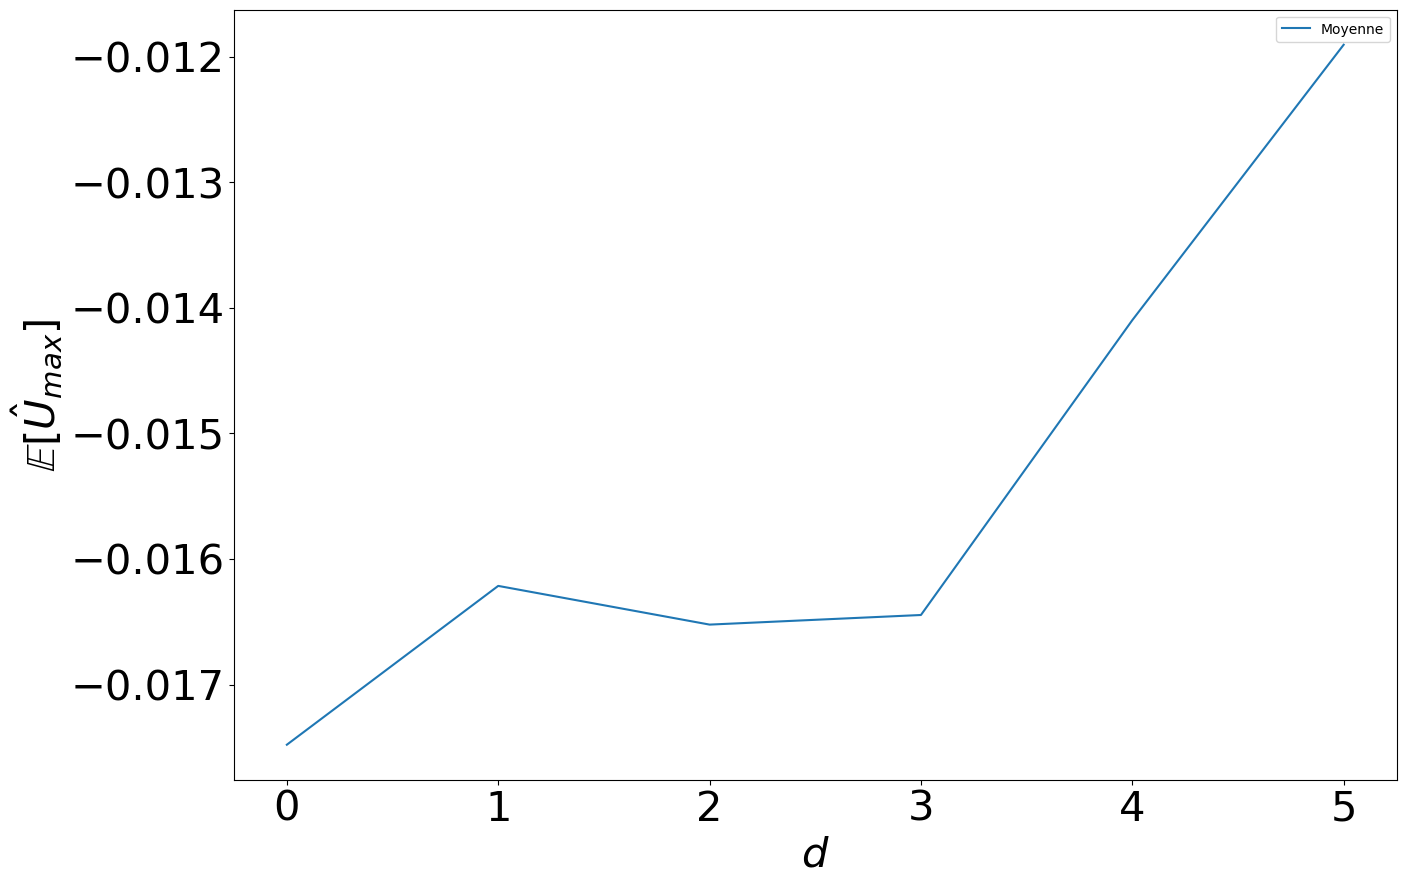

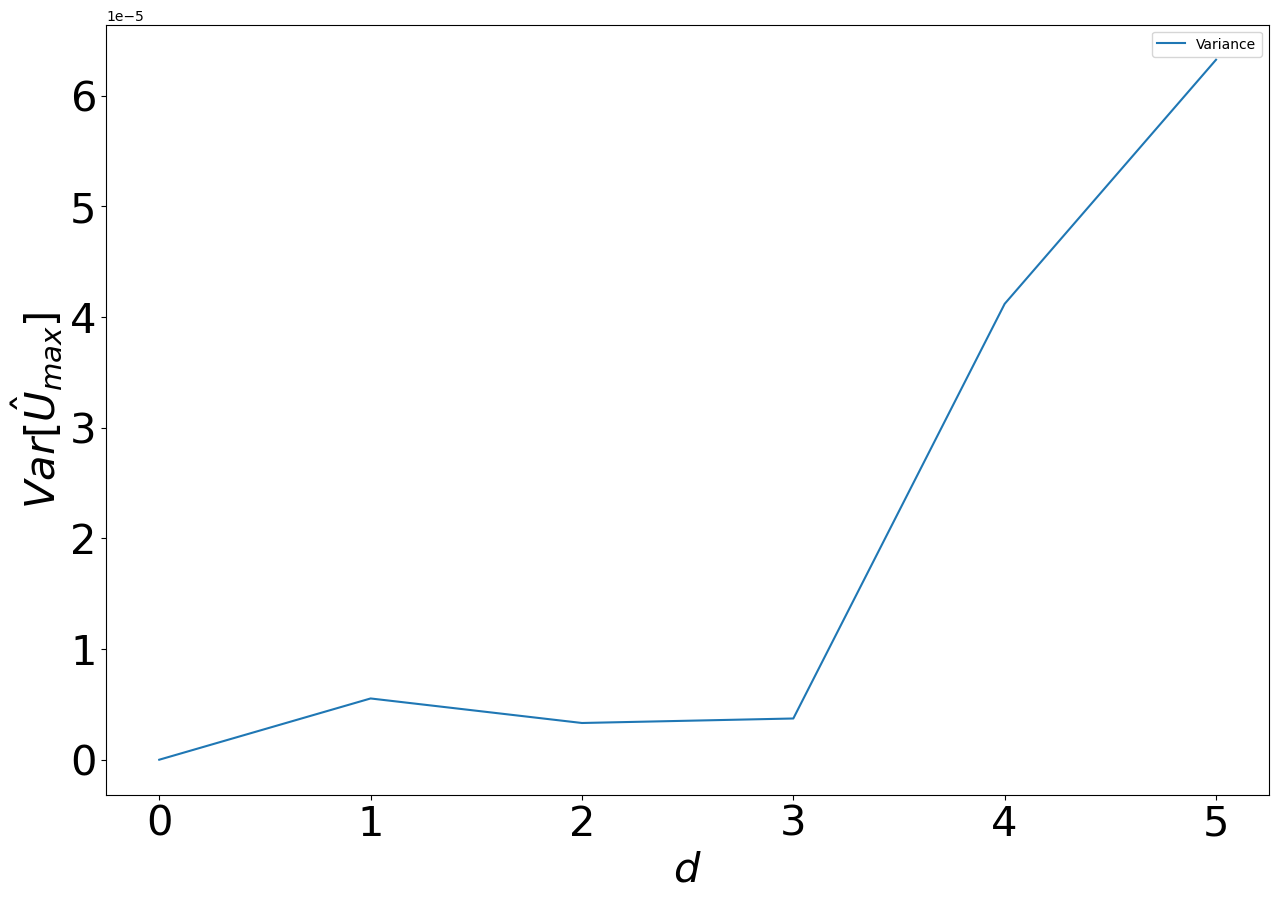

In [82]:
Mean = []
Var = []
D = [0,1,2,3,4,5]
for d in D:
  P = int(math.factorial(n+d)/(math.factorial(n)*math.factorial(d)))
  # P = int(math.factorial(d+n-1)/(math.factorial(d)*math.factorial(n-1)))
  adaptiveStrategy = ot.FixedStrategy(base,P)
  CP = ot.FunctionalChaosAlgorithm(input_sample,output_sample,input_distribution,adaptiveStrategy)
  CP.run()
  result_CP = CP.getResult()
  coefficients = np.array(result_CP.getCoefficients())
  Mean.append(coefficients[0])
  Var.append(np.sum(coefficients[1:]**2))

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$d$',fontsize = 30)
ax.set_ylabel (r'$\mathbb{E}[\hat{U}_{max}]$',fontsize=30)
ax.tick_params(labelsize=30)
ax.plot(D,Mean, label = 'Moyenne')
ax.legend(loc=0)
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$d$',fontsize = 30)
ax.set_ylabel (r'$Var[\hat{U}_{max}]$',fontsize=30)
ax.tick_params(labelsize=30)
ax.plot(D,Var, label = 'Variance')
ax.legend(loc=0)


**Réponse 8)** : On observe que l'espérance et la variance de $U_{max}$ sont stable jusqu'à un degré d'approximation de 3. Cela suggère que la fonction $U_{max}(E,b)$ peut être bien approximée par un polynôme de degré 3.

## 2.3) Analyse de sensibilité

Nous allons à présent exploiter l'approximation par chaos polynomial afin d'estimer les indices de Sobol. Avant cela nous allons, à l'aide de simulations, décrire un peu plus le principe de ces indices.

Dans notre cas d'application à deux variables, nous avons 3 indices, celui de la variable $E$, celui de la variable $B$ et celui caractérisant l'intéraction entre $E$ et $B$. Ce cas simple à deux variables n'est pas très réaliste pour une analyse de sensibilité mais à l'avantage d'être illustratif.

### 2.3.1) Espérance conditionnelle

On rappelle que l'indice de Sobol  de la variable $X_i$ est donnée par :

$$
S_i = \frac{Var[\mathbb{E}[Y|X_i]]}{Var[Y]}
$$

Nous allons donc, dans un premier temps, étudier par simulation la variable aléatoire $\mathbb{E}[Y|X_i]$.

<p class="bg-primary" style="padding:1em">

**Question 9)** : Compléter le code suivant afin de tracer les histogrammes de $\mathbb{E}[U_{max}|E]$ et $\mathbb{E}[U_{max}|B]$. Pour les simulations nous utiliserons l'approximation par chaos polynomial validée précédemment. Expliquer le rôle des variables n_sim_1 et n_sim_2.

In [15]:
##génération d'échantillons
n_sim = 3*P
Echantillon_E = np.array(Loi_E.getSample(n_sim))
Echantillon_b = np.array(Loi_b.getSample(n_sim))
##paramètres
L = 10.0 #longueur en métre
h = 0.1 #hauteur de la section en métre
#Chargement :
#Chargement total
Q_total = -3000.0 #Newton
#Le chargement est réparti uniformement sur les noeuds entre les 2 extremitées
n_elem = 50
n_nodes = n_elem+1
Q_elem = Q_total/n_elem
Q = np.ones((n_nodes,))*Q_elem
#Vecteur U_max
U_max = np.zeros((n_sim,))
##Exécution du code EF pour chaque échantillon
for i in range(n_sim):
    E = Echantillon_E[i]
    b = Echantillon_b[i]
    I = b*h**3/12.0
    l_max,u_max,U = find_max_dep(n_elem,L,E,I,Q)
    U_max[i] = u_max
input_distribution = ot.ComposedDistribution([Loi_E,Loi_b])
adaptiveStrategy = ot.FixedStrategy(base,P)
input_sample = np.concatenate((Echantillon_E,Echantillon_b),axis=1)
output_sample= U_max.reshape((3*P,1))
#Par defaut la méthode utilise les moindres carrés, il n'est donc pas utile de spécifier la projection strategy
CP = ot.FunctionalChaosAlgorithm(input_sample,output_sample,input_distribution,adaptiveStrategy)
CP.run()
result_CP = CP.getResult()
Meta_model = result_CP.getMetaModel()

In [16]:
n_sim_1 = 500
n_sim_2 = 200
#Esperance de U_max sachant E
E_U_E = []
sample_E = input_distribution.getSample(n_sim_1) # A compléter
for i in range(n_sim_1):
    sample_B = input_distribution.getSample(n_sim_2) #A Completer
    X = np.zeros((n_sim_2,2))
    X[:,0]=sample_E[i,0]*np.ones(n_sim_2) #A Completer
    X[:,1]=np.array(sample_B[:,1]).flatten() #A Completer
    U_e = Meta_model(X)
    E_U_E.append(np.mean(U_e)) #A Completer
E_U_E = np.array(E_U_E)


#Esperance de U_max sachant B
E_U_B = []
sample_B = input_distribution.getSample(n_sim_1) #A Completer
for i in range(n_sim_1):
    sample_E = input_distribution.getSample(n_sim_2) #A Completer
    X = np.zeros((n_sim_2,2))
    X[:,0]=np.array(sample_E[:,0]).flatten() #A Completer
    X[:,1]=sample_B[i,1]*np.ones(n_sim_2) #A Completer
    U_b = Meta_model(X)
    E_U_B.append(np.mean(U_b)) #A Completer
E_U_B = np.array(E_U_B)


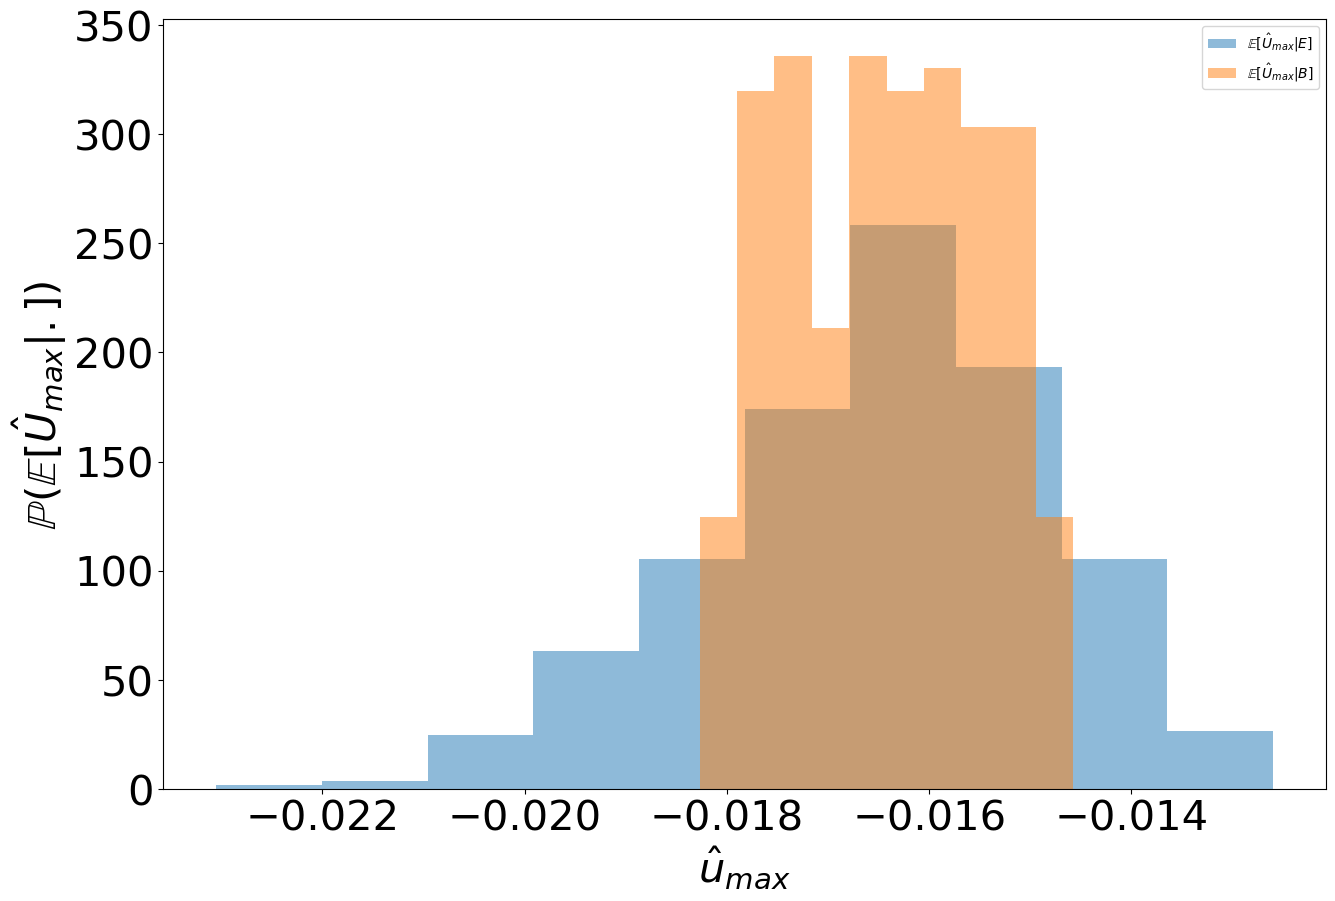

In [17]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$\hat{u}_{max}$',fontsize = 30)
ax.tick_params(labelsize=30)
ax.hist(E_U_E, label = r'$\mathbb{E}[\hat{U}_{max}|E]$', density=True, alpha = 0.5)
ax.hist(E_U_B, label = r'$\mathbb{E}[\hat{U}_{max}|B]$', density=True, alpha = 0.5)
ax.set_ylabel (r'$\mathbb{P}(\mathbb{E}[\hat{U}_{max}|.])$',fontsize=30)
ax.legend(loc=0)

**Réponse 9)** : Le rôle des variables n_sim_1 et n_sim_2 est de définir le nombre de simulations à effectuer pour estimer les espérances conditionnelles. n_sim_1 correspond au nombre de simulations pour la variable E, tandis que n_sim_2 correspond au nombre de simulations pour la variable B.

<p class="bg-primary" style="padding:1em">

**Question 10)** : A l'aide des histogrammes pouvez-vous conclure sur l'analyse de sensibilité du problème?

**Réponse 10)** : En observant les histogrammes on peut conclure que la variable $E$ est plus influente que la variable $B$ sur le déplacement maximal de la passerelle. En effet, l'histogramme de $\mathbb{E}[U_{max}|E]$ est plus dispersé que celui de $\mathbb{E}[U_{max}|B]$. Par conséquent, la variance de $\mathbb{E}[U_{max}|E]$ est plus grande que celle de $\mathbb{E}[U_{max}|B]$ et par conséquent l'indice de Sobol de $E$ est plus grand que celui de $B$.

<p class="bg-primary" style="padding:1em">

**Question 11)** : A l'aide des simulations précédentes donner une estimation des indices de sensibilité. Pour cela vous completerez le code suivant. Quelle est l'influence de n_sim_1 et n_sim_2. Ces estimations sont-elles cohérentes avec vos conclusions précédentes?

In [90]:
S_E = np.var(E_U_E)/np.var(U_max) #A Completer
S_B = np.var(E_U_B)/np.var(U_max) #A Completer
print("Indice $S_E$=", S_E)
print("Indice $S_B$=", S_B)

Indice $S_E$= 0.7274199894660661
Indice $S_B$= 0.2611280219342129


**Réponse 11)** : On voit que l'indice de Sobol de $E$ est plus grand que celui de $B$ ce qui est cohérent avec nos conclusions précédentes. Par ailleurs, on voit que les indices de Sobol sont plus sensibles à n_sim_1 qu'à n_sim_2. En effet, n_sim_1 correspond au nombre de réalisations de la variable aléatoire $X_i$ alors que n_sim_2 correspond au nombre de réalisations de la variable aléatoire $Y$ conditionnée à une réalisation de $X_i$. Par conséquent, n_sim_1 a un impact plus important sur la variance de $\mathbb{E}[Y|X_i]$ que n_sim_2.

### 2.3.2) Estimation des indices de sensibilité en exploitant les coefficients de l'approximation par chaos polynomial

Nous allons à présent estimer les indices de sensibilité à l'aide des formules vues en cours. Pour cela, nous utiliserons les fonctions déjà codées dans la bibliothèque openturns https://openturns.github.io/openturns/latest/user_manual/_generated/openturns.FunctionalChaosSobolIndices.html?highlight=functionalchaossobolindices#openturns.FunctionalChaosSobolIndices

et

https://openturns.github.io/openturns/latest/auto_sensitivity_analysis/plot_functional_chaos_sensitivity.html?highlight=functionalchaossobolindices

<p class="bg-primary" style="padding:1em">

**Question 12)** : Compléter le code suivant afin d'effectuer l'analyse de sensibilité en exploitant l'approximation par chaos polynomial validée précédemment. Les résultats sont-ils en accord avec vos estimations précédentes?

In [96]:
chaosSI = ot.FunctionalChaosSobolIndices(result_CP) #A Completer
print(chaosSI)

FunctionalChaosSobolIndices
- input dimension=2
- output dimension=1
- basis size=21
- mean=[-0.0164623]
- std-dev=[0.00190523]

| Index | Multi-index   | Variance part |
|-------|---------------|---------------|
|     1 | [1,0]         | 0.731904      |
|     2 | [0,1]         | 0.250223      |
|     3 | [2,0]         | 0.0142627     |

| Input | Name          | Sobol' index  | Total index   |
|-------|---------------|---------------|---------------|
|     0 | X0            | 0.746599      | 0.749105      |
|     1 | X1            | 0.250895      | 0.253401      |




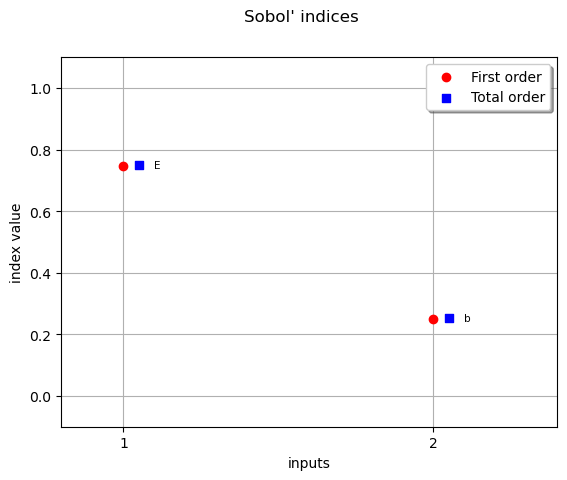

In [97]:
#to draw the indices
import openturns.viewer as viewer
from matplotlib import pylab as plt
input_names = ['E', 'b']
n = 2
first_order = [chaosSI.getSobolIndex(i) for i in range(n)]
total_order = [chaosSI .getSobolTotalIndex(
    i) for i in range(n)]
graph = ot.SobolIndicesAlgorithm.DrawSobolIndices(
    input_names, first_order, total_order)
view = viewer.View(graph)

**Réponse 12)** : Les indices de Sobol obtenus sont $S_E \simeq 0.75$ et $S_b \simeq 0.25$. Ces valeurs confirment parfaitement l’analyse qualitative issue des histogrammes : la variable $E$ contribue majoritairement à la variance de $U_{\max}$, tandis que l’effet de $b$ reste nettement plus faible.

Les indices totaux étant très proches des indices de premier ordre, les effets d’interaction sont négligeables. La sensibilité est dominée par les contributions individuelles de $E$ et $b$.

## 2.4) Fiabilité par approximation par chaos polynomial
On rappele que le problème de fiabilité est définie par la fonction de performance
$$
G(X) = d_{seuil}-|u_{max}(X)|
$$
avec $d_{seuil}=0.022$.

<p class="bg-primary" style="padding:1em">

**Question 13)** : Proposer une approche afin d'estimer la probablité de défaillance à l'aide de l'approximation par CP?

In [18]:
d_seuil = 0.022

n_sim_pf = 1_000_000
input_sample_pf = input_distribution.getSample(n_sim_pf)

U_pf = np.array(Meta_model(input_sample_pf)).flatten()

Pf = np.mean(np.abs(U_pf) >= d_seuil)
CV = np.sqrt(Pf * (1 - Pf) / n_sim_pf) / Pf

print("Pf CP =", Pf)
print("CV PF =", CV)

Pf CP = 0.00255
CV PF = 0.019777685980546307


On dispose d'un méta-modèle par chaos polynomial $\hat{u}_{\max}(X)$ approchant le déplacement maximal $u_{\max}(X)$ à partir des variables aléatoires d'entrée $X = (E,b)$. La fonction de performance est définie par
$$
G(X) = d_{\text{seuil}} - \lvert u_{\max}(X)\rvert,
\quad \text{avec } d_{\text{seuil}} = 0.022.
$$
La défaillance correspond à l'événement $G(X) \leq 0$, soit
$$
\lvert u_{\max}(X)\rvert \geq d_{\text{seuil}}.
$$
Pour estimer la probabilité de défaillance, on remplace $u_{\max}$ par le méta-modèle $\hat{u}_{\max}$ et on applique une simulation de Monte Carlo de grande taille $N$ :
$$
\hat{P}_f^{CP} = \frac{1}{N} \sum_{k=1}^N \mathbf{1}_{\{ \lvert \hat{u}_{\max}(X^{(k)}) \rvert \geq d_{\text{seuil}} \}},
$$
où les $X^{(k)}$ sont tirés indépendamment suivant la loi d'entrée.

Avec $N = 10^6$ simulations, on obtient :
$$
\hat{P}_f^{CP} = 2.55 \times 10^{-3},
$$
ce qui signifie qu'environ $0.255\,\%$ des configurations mènent à une défaillance (dépassement du seuil de déplacement). Le coefficient de variation de l'estimateur de Monte Carlo vaut
$$
\text{CV} \approx 0.02,
$$
soit une erreur relative d'environ $2\,\%$, ce qui indique que l'estimation de la probabilité de défaillance est statistiquement très précise grâce à l'utilisation du chaos polynomial comme méta-modèle peu coûteux.

<p class="bg-primary" style="padding:1em">

**Question Bonus** : Le coefficient de variation calculé précédemment ne prend en compte que la variation du plan de Monte Carlo mais pas l'approximation par CP. Faite une recherche sur le ré échantillonnage bootstrap et proposer une approche pour quantifier l'incertitude liée à l'approximation par chaos polynomial. On pourra appliquer cette démarche à l'estimation des indices de sensibilité et à l'estimation de la probabilité de défaillance.   